In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
%matplotlib inline
from acquire import get_items, get_stores, get_sales, get_complete_data, acquire_germany
import prepare
from prepare import prep_opsd_data

# set figure size
plt.rcParams["figure.figsize"] = (10,8)

# specify decimal places to display
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read in and prepare the store data:
df = pd.read_csv('complete_data.csv')



In [28]:
df.head()

,Unnamed: 0,item_id,sale_amount,sale_date,sale_id,store_id,store_address,store_city,store_state,store_zipcode,item_brand,item_name,item_price,item_upc12,item_upc14
0,0,1,13.00,"Tue, 01 Jan 2013 00:00:00 GMT",1,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013
1,1,1,13.00,"Tue, 01 Jan 2013 00:00:00 GMT",1,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013
2,2,1,11.00,"Wed, 02 Jan 2013 00:00:00 GMT",2,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013
3,3,1,11.00,"Wed, 02 Jan 2013 00:00:00 GMT",2,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013
4,4,1,14.00,"Thu, 03 Jan 2013 00:00:00 GMT",3,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013


In [29]:
df = prepare.prep_store_data(df)

In [30]:
# look at max and min dates
df.index.min(), df.index.max()

(Timestamp('2013-01-01 00:00:00+0000', tz='GMT'),
 Timestamp('2017-12-31 00:00:00+0000', tz='GMT'))

In [31]:
# Train test split:

train = df[:'2016']
test = df['2017']

<AxesSubplot:xlabel='sale_date'>

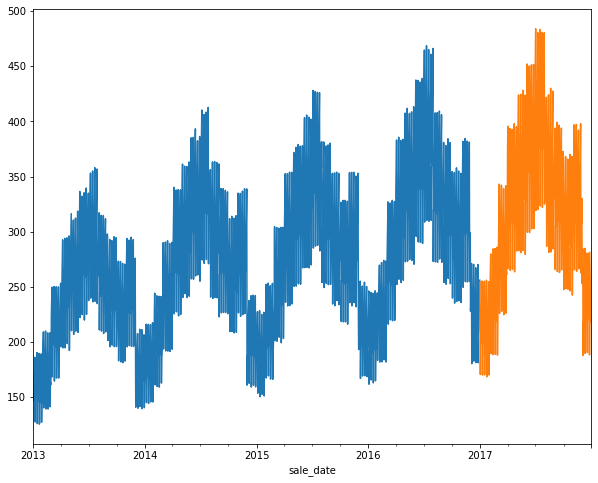

In [32]:
# Visualize the split data:

train.resample('D').sales_total.mean().plot()
test.resample('D').sales_total.mean().plot()

In [33]:
# y is the resampled daily data:

y = train.resample('D').sales_total.mean()
y.head()

sale_date
2013-01-01 00:00:00+00:00   147.69
2013-01-02 00:00:00+00:00   147.14
2013-01-03 00:00:00+00:00   156.34
2013-01-04 00:00:00+00:00   168.94
2013-01-05 00:00:00+00:00   175.24
Freq: D, Name: sales_total, dtype: float64

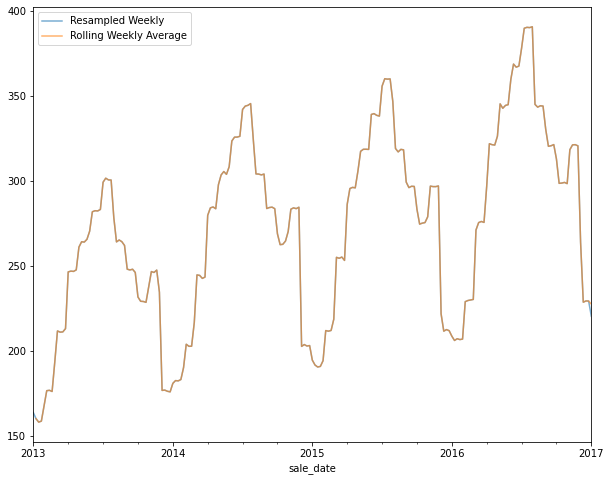

In [14]:
#Plot the weekly average & the 7-day moving average. Compare the 2 plots.

y.resample('W').mean().plot(label='Resampled Weekly', alpha=.6)
y.rolling(7).mean().plot(label='Rolling Weekly Average', alpha=.6)
plt.legend()

Text(0, 0.5, 'Difference in sales from one day to the next')

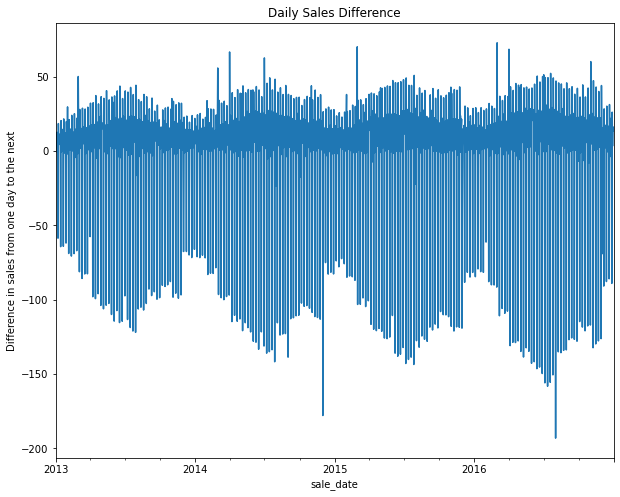

In [34]:
# Plot the daily difference. 
# Observe whether usage seems to vary drastically from day to day or has more of a smooth transition.

y.diff().plot()
plt.title('Daily Sales Difference')
plt.ylabel('Difference in sales from one day to the next')

Text(0, 0.5, '% Change')

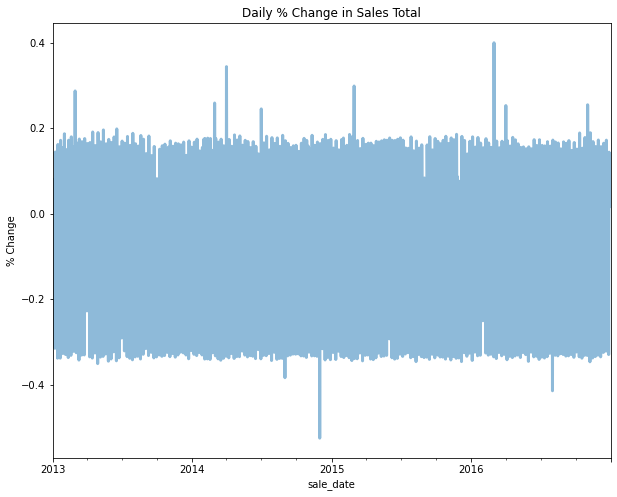

In [35]:
# Maybe it would be helpful to look at percent change as well:

(y.diff() / y.shift()).plot(alpha=.5, lw=3)
plt.title('Daily % Change in Sales Total')
plt.ylabel('% Change')

[Text(0.5, 1.0, 'Monthly % Change in Sales Total')]

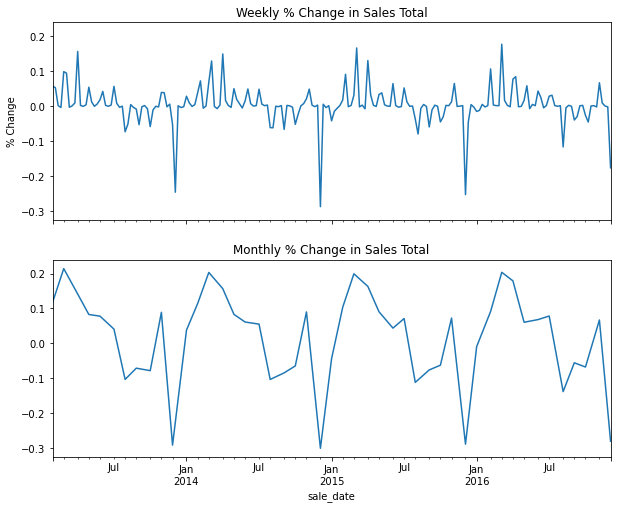

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

weekly = y.resample('W').mean()
(weekly.diff() / weekly.shift()).plot(ax=ax1)
ax1.set(title='Weekly % Change in Sales Total', ylabel='% Change', xlabel='')

monthly = y.resample('M').mean()
(monthly.diff() / monthly.shift()).plot(ax=ax2)
ax2.set(title='Monthly % Change in Sales Total')
# ax2.hlines(0, *ax2.get_xlim())

In [36]:
#Weekly resample
y.resample('W').mean()

sale_date
2013-01-06 00:00:00+00:00   163.59
2013-01-13 00:00:00+00:00   159.98
2013-01-20 00:00:00+00:00   157.95
2013-01-27 00:00:00+00:00   158.55
2013-02-03 00:00:00+00:00   167.59
                             ...  
2016-12-04 00:00:00+00:00   263.77
2016-12-11 00:00:00+00:00   228.56
2016-12-18 00:00:00+00:00   229.30
2016-12-25 00:00:00+00:00   229.23
2017-01-01 00:00:00+00:00   220.28
Freq: W-SUN, Name: sales_total, Length: 209, dtype: float64

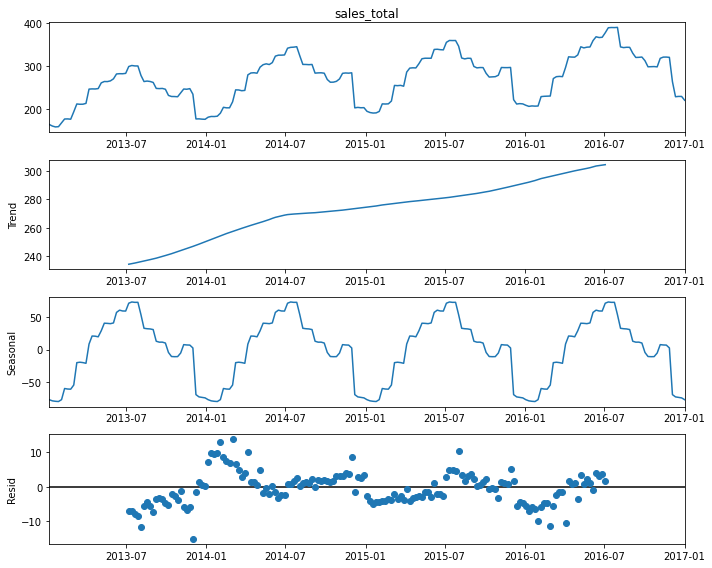

In [37]:
# Seasonal decomposistion
sm.tsa.seasonal_decompose(y.resample('W').mean()).plot()
None

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

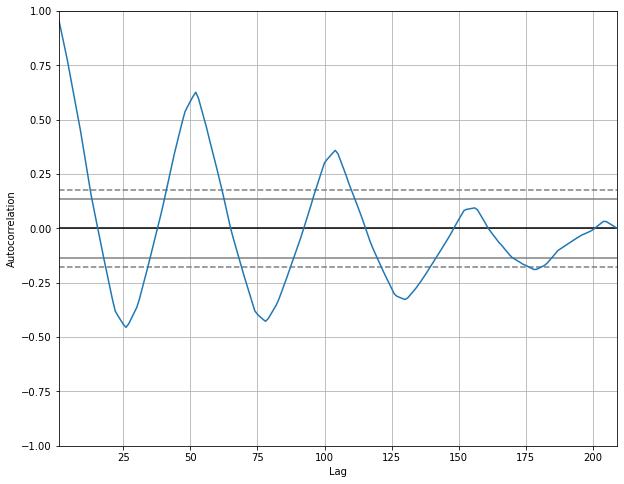

In [38]:
# Autocorrelation after weekly resampling:

pd.plotting.autocorrelation_plot(y.resample('W').mean())

# Germany 

In [3]:
germany = pd.read_csv('opsd_germany_daily.csv', index_col=0)


In [4]:
germany.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.18,nan,nan,nan
2006-01-02,1380.52,nan,nan,nan
2006-01-03,1442.53,nan,nan,nan
2006-01-04,1457.22,nan,nan,nan
2006-01-05,1477.13,nan,nan,nan


In [6]:
germany = prepare.get_germany()

In [7]:
germany.head()

,Consumption,Wind,Solar,Wind+Solar,month,year
Date,,,,,,
2006-01-01,1069.18,164.81,89.26,272.66,January,2006
2006-01-02,1380.52,164.81,89.26,272.66,January,2006
2006-01-03,1442.53,164.81,89.26,272.66,January,2006
2006-01-04,1457.22,164.81,89.26,272.66,January,2006
2006-01-05,1477.13,164.81,89.26,272.66,January,2006


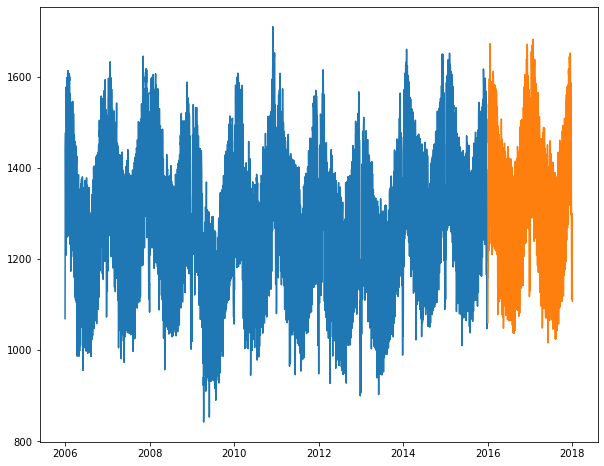

In [15]:
# split the data:
    
train = germany[:'2015']
test = germany['2016':]

plt.plot(train.index, train.Consumption)
plt.plot(test.index, test.Consumption)

In [16]:
train.head()

,Consumption,Wind,Solar,Wind+Solar,month,year
Date,,,,,,
2006-01-01,1069.18,164.81,89.26,272.66,January,2006
2006-01-02,1380.52,164.81,89.26,272.66,January,2006
2006-01-03,1442.53,164.81,89.26,272.66,January,2006
2006-01-04,1457.22,164.81,89.26,272.66,January,2006
2006-01-05,1477.13,164.81,89.26,272.66,January,2006


In [17]:
y = train.Consumption
y.head()

Date
2006-01-01   1069.18
2006-01-02   1380.52
2006-01-03   1442.53
2006-01-04   1457.22
2006-01-05   1477.13
Name: Consumption, dtype: float64

<AxesSubplot:ylabel='Frequency'>

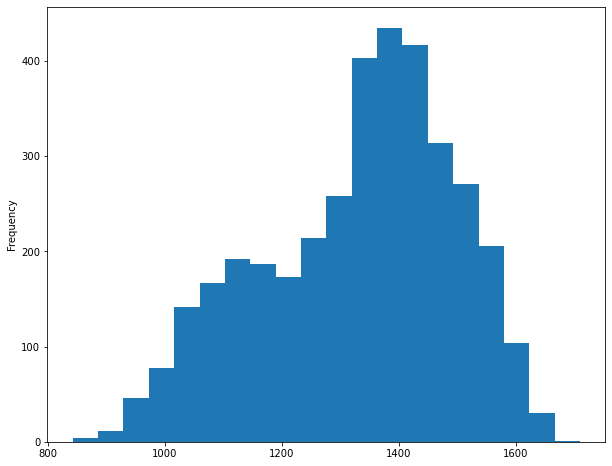

In [18]:
y.plot.hist(bins=20)

In [19]:
train['month'] = y.index.month
train.head()

,Consumption,Wind,Solar,Wind+Solar,month,year
Date,,,,,,
2006-01-01,1069.18,164.81,89.26,272.66,1,2006
2006-01-02,1380.52,164.81,89.26,272.66,1,2006
2006-01-03,1442.53,164.81,89.26,272.66,1,2006
2006-01-04,1457.22,164.81,89.26,272.66,1,2006
2006-01-05,1477.13,164.81,89.26,272.66,1,2006


<AxesSubplot:xlabel='month'>

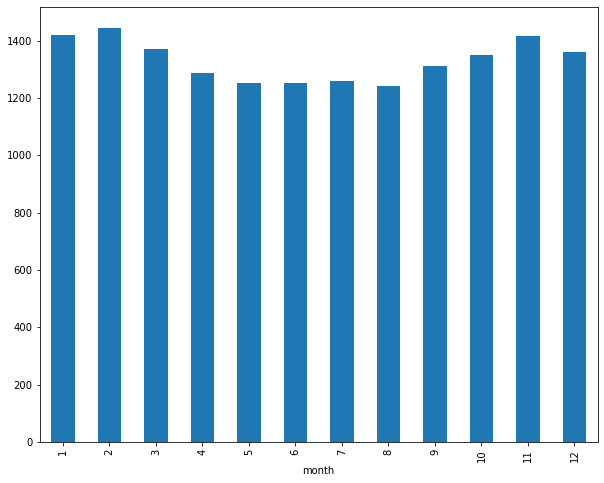

In [20]:
train.groupby('month').Consumption.mean().plot.bar()

In [21]:
train['weekday'] = y.index.day_name()
train.head()

,Consumption,Wind,Solar,Wind+Solar,month,year,weekday
Date,,,,,,,
2006-01-01,1069.18,164.81,89.26,272.66,1,2006,Sunday
2006-01-02,1380.52,164.81,89.26,272.66,1,2006,Monday
2006-01-03,1442.53,164.81,89.26,272.66,1,2006,Tuesday
2006-01-04,1457.22,164.81,89.26,272.66,1,2006,Wednesday
2006-01-05,1477.13,164.81,89.26,272.66,1,2006,Thursday


<AxesSubplot:xlabel='weekday'>

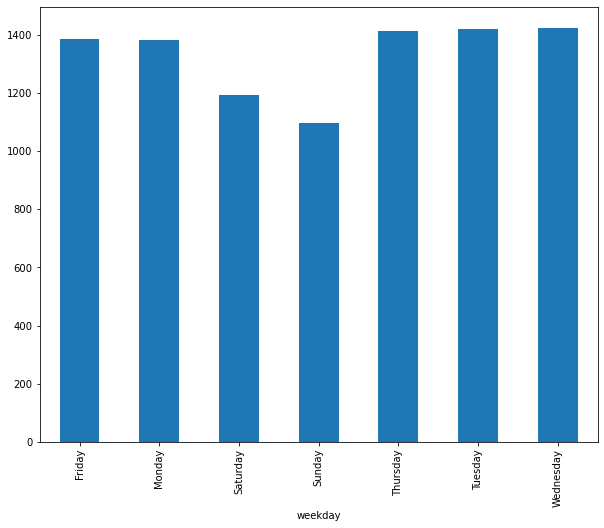

In [22]:

train.groupby('weekday').Consumption.mean().plot.bar()

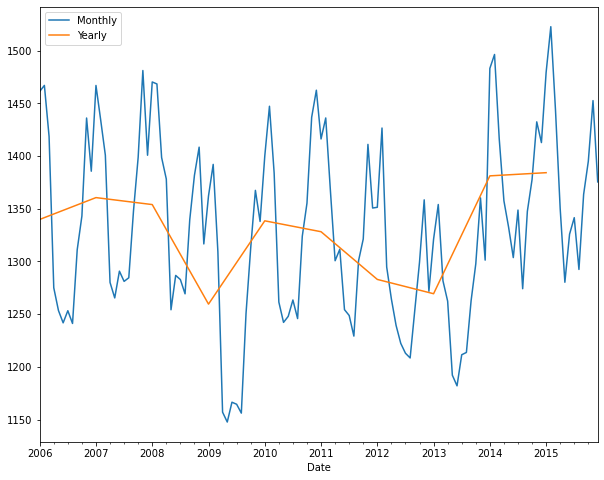

In [26]:
y.resample('M').mean().plot(label = 'Monthly')
y.resample('Y').mean().plot(label = 'Yearly')
plt.legend()

<AxesSubplot:title={'center':'2 week average'}, xlabel='Date'>

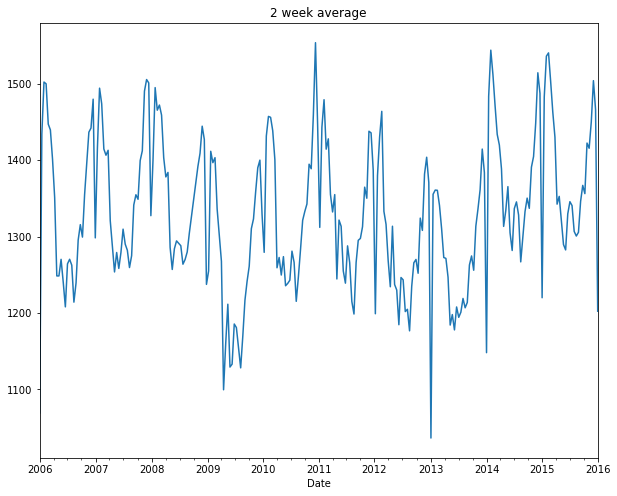

In [25]:
y.resample('2W').mean().plot(title='2 week average')


<AxesSubplot:xlabel='month', ylabel='Consumption'>

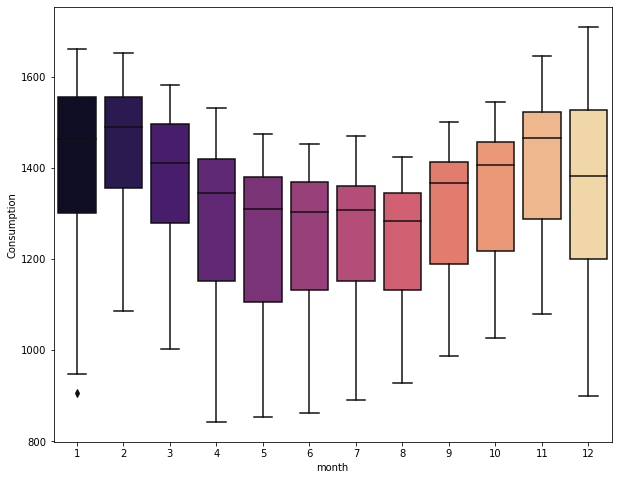

In [24]:
sns.boxplot(data=train, x='month', y='Consumption', palette='magma')


<AxesSubplot:xlabel='Date'>

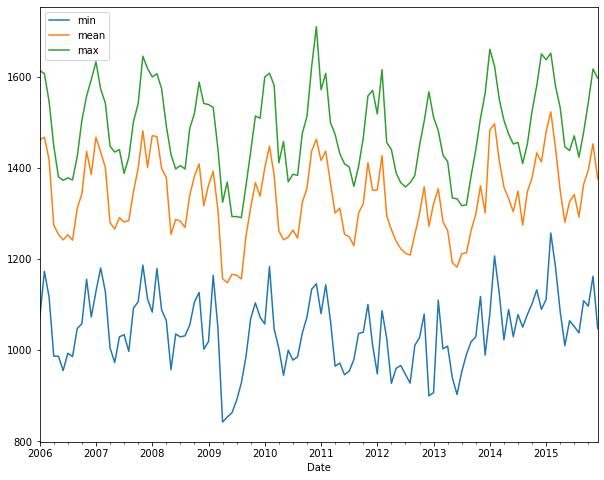

In [27]:
y.resample('M').agg(['min', 'mean', 'max']).plot()


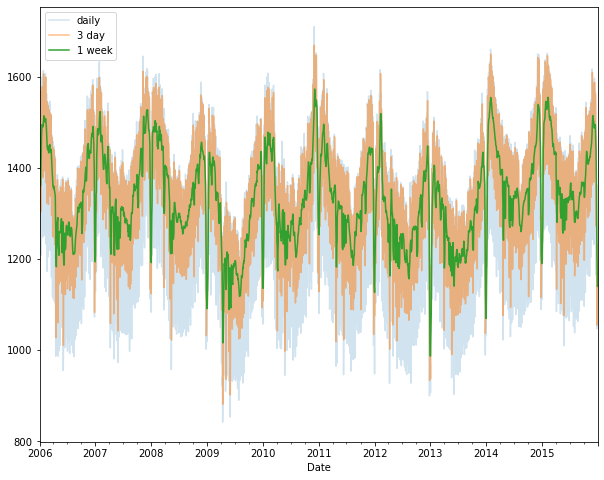

In [28]:
y.plot(alpha=.2, label='daily')
y.resample('D').mean().rolling(3).mean().plot(alpha=.5, label='3 day')
y.resample('D').mean().rolling(7).mean().plot(alpha=8, label='1 week')
plt.legend()

In [29]:
y.resample('W').mean().diff()


Date
2006-01-01       nan
2006-01-08    312.12
2006-01-15    105.43
2006-01-22      3.30
2006-01-29     24.15
               ...  
2015-12-06    -18.91
2015-12-13     -2.11
2015-12-20    -52.38
2015-12-27   -243.54
2016-01-03     15.96
Freq: W-SUN, Name: Consumption, Length: 523, dtype: float64

<AxesSubplot:title={'center':'Average week-to-week change in consumption'}, xlabel='Date'>

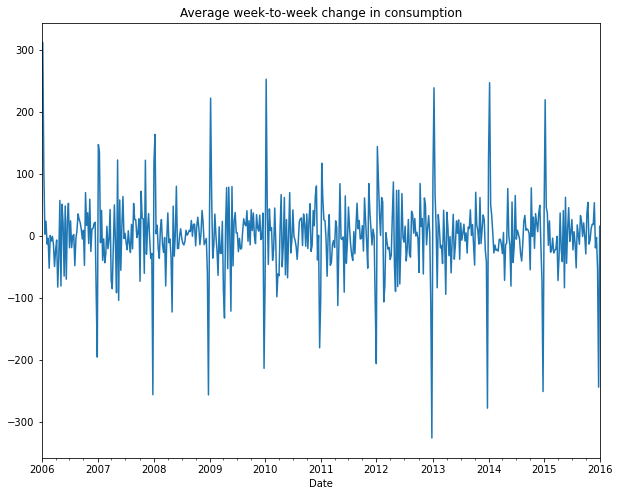

In [30]:
y.resample('W').mean().diff().plot(title='Average week-to-week change in consumption')


In [32]:
# unstack is similar to pivot_table. It turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0)


Date,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Date,,,,,,,,,,
1,1461.44,1467.06,1470.37,1362.26,1400.04,1416.29,1351.44,1321.19,1483.26,1479.45
2,1467.11,1434.48,1468.49,1392.16,1447.32,1436.21,1426.67,1354.09,1496.47,1522.84
3,1418.65,1400.91,1398.65,1309.22,1383.87,1366.99,1294.75,1281.67,1416.46,1443.59
4,1275.06,1280.13,1378.24,1157.01,1261.51,1300.73,1264.43,1262.36,1357.58,1350.11
5,1253.49,1265.44,1254.19,1147.65,1242.22,1311.61,1239.39,1192.12,1332.49,1280.31
6,1241.78,1290.83,1286.80,1166.46,1247.94,1254.29,1222.32,1182.00,1303.71,1325.95
7,1253.30,1281.13,1282.87,1164.52,1263.47,1248.77,1212.95,1211.50,1348.81,1341.60
8,1241.19,1284.55,1269.32,1156.11,1245.83,1229.20,1208.47,1213.69,1274.17,1292.47
9,1311.17,1347.86,1339.62,1250.59,1324.00,1300.71,1254.10,1262.72,1347.64,1363.73


<AxesSubplot:xlabel='Date'>

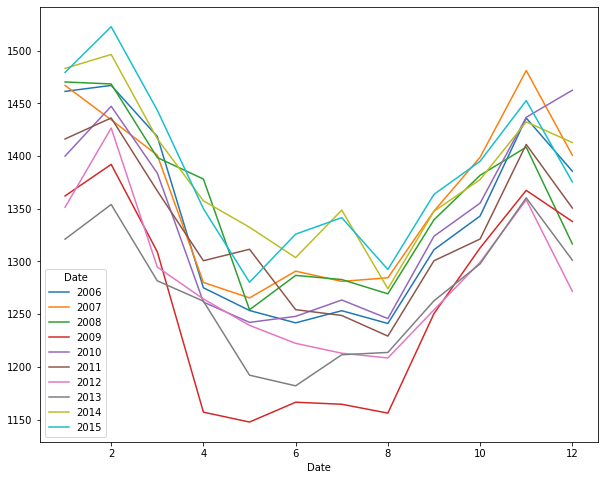

In [33]:
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot()

In [34]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()
table

Date,1,2,3,4,5,6,7,8,9,10,11,12
Date,,,,,,,,,,,,
2006,1461.44,1467.11,1418.65,1275.06,1253.49,1241.78,1253.30,1241.19,1311.17,1343.16,1436.16,1385.69
2007,1467.06,1434.48,1400.91,1280.13,1265.44,1290.83,1281.13,1284.55,1347.86,1398.92,1481.24,1400.84
2008,1470.37,1468.49,1398.65,1378.24,1254.19,1286.80,1282.87,1269.32,1339.62,1381.79,1408.51,1316.67
2009,1362.26,1392.16,1309.22,1157.01,1147.65,1166.46,1164.52,1156.11,1250.59,1312.90,1367.51,1338.00
2010,1400.04,1447.32,1383.87,1261.51,1242.22,1247.94,1263.47,1245.83,1324.00,1355.39,1436.85,1462.56
2011,1416.29,1436.21,1366.99,1300.73,1311.61,1254.29,1248.77,1229.20,1300.71,1321.34,1411.14,1350.76
2012,1351.44,1426.67,1294.75,1264.43,1239.39,1222.32,1212.95,1208.47,1254.10,1299.33,1358.51,1271.77
2013,1321.19,1354.09,1281.67,1262.36,1192.12,1182.00,1211.50,1213.69,1262.72,1297.77,1360.43,1301.30
2014,1483.26,1496.47,1416.46,1357.58,1332.49,1303.71,1348.81,1274.17,1347.64,1377.75,1432.53,1412.86


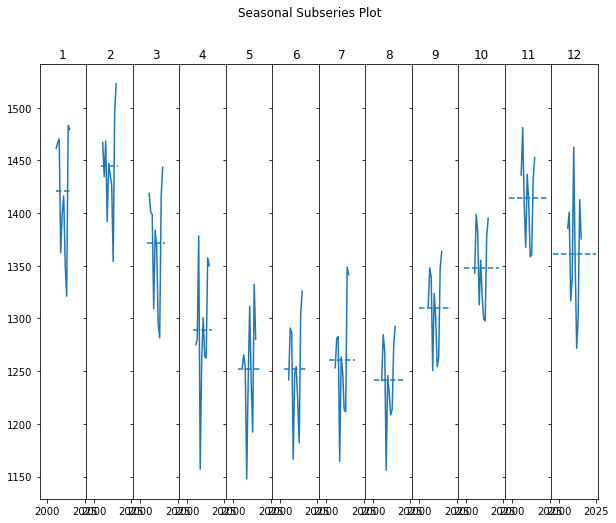

In [35]:
fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    x_left, x_right = ax.get_xlim()
    ax.hlines(subset.mean(), x_left, x_right, ls='--')
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

In [36]:
y.shift(-1)

Date
2006-01-01   1380.52
2006-01-02   1442.53
2006-01-03   1457.22
2006-01-04   1477.13
2006-01-05   1403.43
               ...  
2015-12-27   1219.08
2015-12-28   1233.66
2015-12-29   1238.86
2015-12-30   1158.10
2015-12-31       nan
Name: Consumption, Length: 3652, dtype: float64

Text(0.5, 1.0, 'Lag plot with lag = 1')

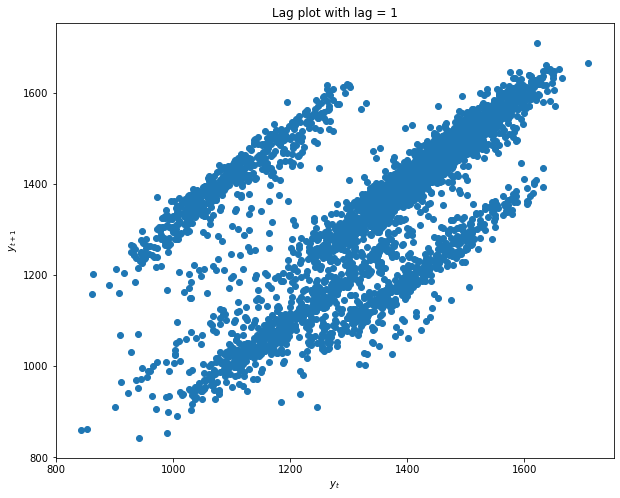

In [37]:

plt.scatter(y, y.shift(-1))
plt.xlabel('$y_t$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag = 1')

<AxesSubplot:xlabel='Consumption', ylabel='consumption_next_day'>

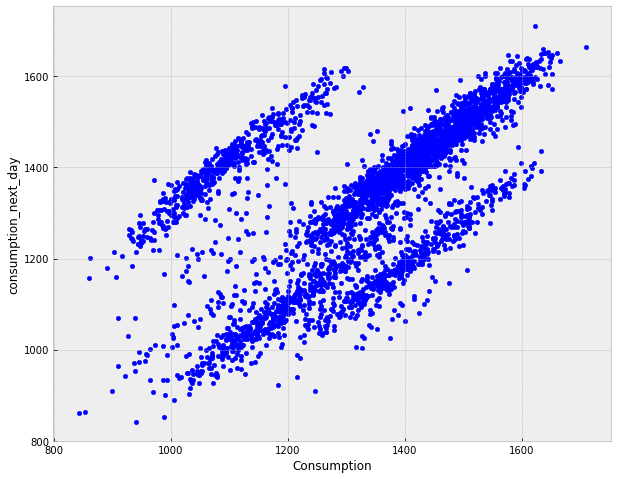

In [38]:
plt.style.use('bmh')
daily = train.resample('D').mean()
daily['consumption_next_day'] = daily.Consumption.shift(-1)
daily.plot.scatter(x='Consumption', y='consumption_next_day')

,this_week,Wind,Solar,Wind+Solar,month,year,1_weeks_out
Date,,,,,,,
2006-01-01,1069.18,164.81,89.26,272.66,1.00,2006.00,1381.30
2006-01-08,1381.30,164.81,89.26,272.66,1.00,2006.00,1486.73
2006-01-15,1486.73,164.81,89.26,272.66,1.00,2006.00,1490.03
2006-01-22,1490.03,164.81,89.26,272.66,1.00,2006.00,1514.18
2006-01-29,1514.18,164.81,89.26,272.66,1.00,2006.00,1501.40
...,...,...,...,...,...,...,...
2015-12-06,1494.49,472.53,23.43,495.95,11.86,2015.00,1492.38
2015-12-13,1492.38,317.98,30.11,348.09,12.00,2015.00,1440.00
2015-12-20,1440.00,258.15,20.91,279.06,12.00,2015.00,1196.46


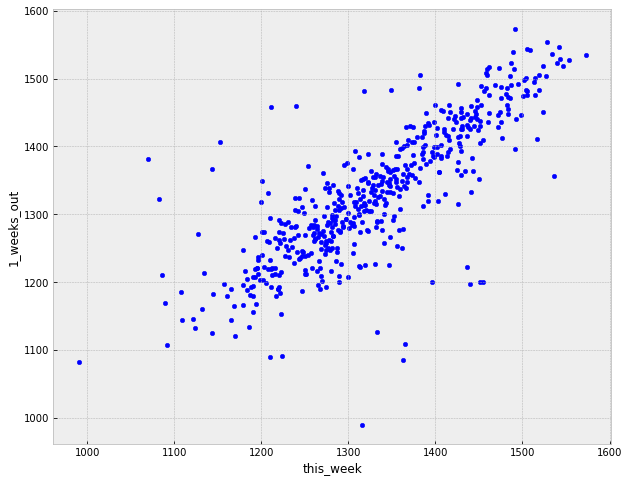

In [39]:
weekly = train.resample('W').mean()
weekly['1_weeks_out'] = weekly.Consumption.shift(-1)
weekly = weekly.rename(columns={'Consumption': 'this_week'})
weekly.plot.scatter(x='this_week', y='1_weeks_out')
weekly

,this_week,Wind,Solar,Wind+Solar,month,year,12_weeks_out
Date,,,,,,,
2006-01-01,1069.18,164.81,89.26,272.66,1.00,2006.00,1376.69
2006-01-08,1381.30,164.81,89.26,272.66,1.00,2006.00,1354.12
2006-01-15,1486.73,164.81,89.26,272.66,1.00,2006.00,1347.88
2006-01-22,1490.03,164.81,89.26,272.66,1.00,2006.00,1265.72
2006-01-29,1514.18,164.81,89.26,272.66,1.00,2006.00,1231.14
...,...,...,...,...,...,...,...
2015-12-06,1494.49,472.53,23.43,495.95,11.86,2015.00,nan
2015-12-13,1492.38,317.98,30.11,348.09,12.00,2015.00,nan
2015-12-20,1440.00,258.15,20.91,279.06,12.00,2015.00,nan


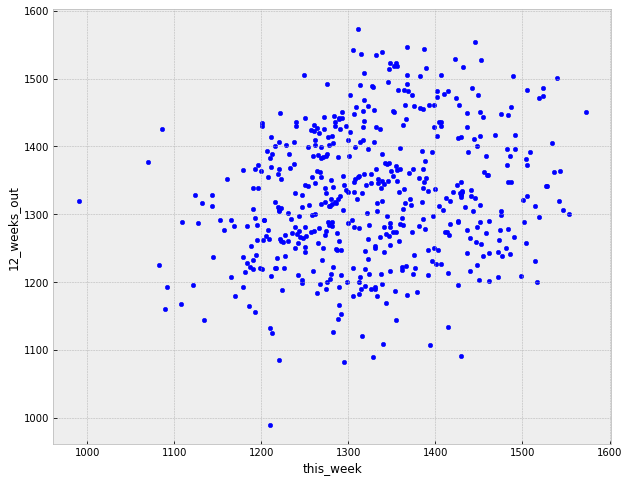

In [40]:
weekly = train.resample('W').mean()
weekly['12_weeks_out'] = weekly.Consumption.shift(-12)
weekly = weekly.rename(columns={'Consumption': 'this_week'})
weekly.plot.scatter(x='this_week', y='12_weeks_out')
weekly

,this_week,Wind,Solar,Wind+Solar,month,year,26_weeks_out
Date,,,,,,,
2006-01-01,1069.18,164.81,89.26,272.66,1.00,2006.00,1254.90
2006-01-08,1381.30,164.81,89.26,272.66,1.00,2006.00,1279.51
2006-01-15,1486.73,164.81,89.26,272.66,1.00,2006.00,1260.95
2006-01-22,1490.03,164.81,89.26,272.66,1.00,2006.00,1261.18
2006-01-29,1514.18,164.81,89.26,272.66,1.00,2006.00,1263.76
...,...,...,...,...,...,...,...
2015-12-06,1494.49,472.53,23.43,495.95,11.86,2015.00,nan
2015-12-13,1492.38,317.98,30.11,348.09,12.00,2015.00,nan
2015-12-20,1440.00,258.15,20.91,279.06,12.00,2015.00,nan


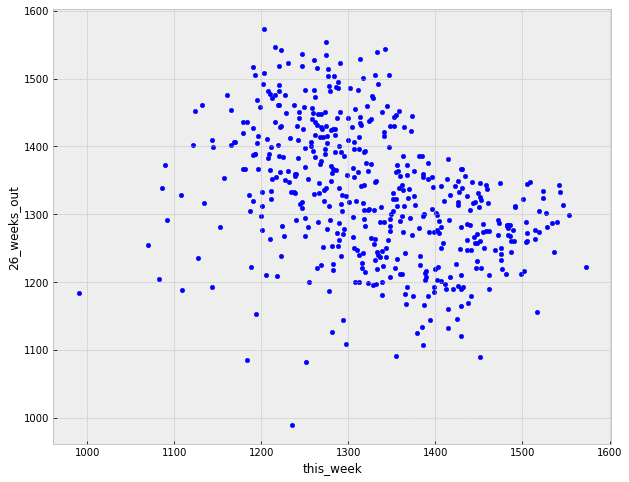

In [41]:
weekly = train.resample('W').mean()
weekly['26_weeks_out'] = weekly.Consumption.shift(-26)
weekly = weekly.rename(columns={'Consumption': 'this_week'})
weekly.plot.scatter(x='this_week', y='26_weeks_out')
weekly

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 26)'>

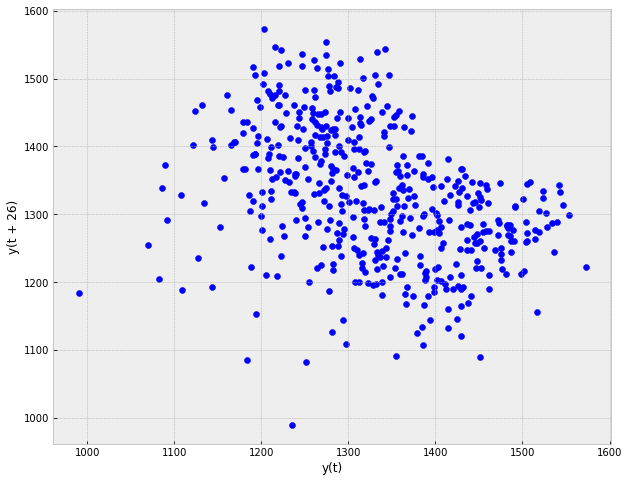

In [42]:
pd.plotting.lag_plot(train.Consumption.resample('W').mean(), lag=26)


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

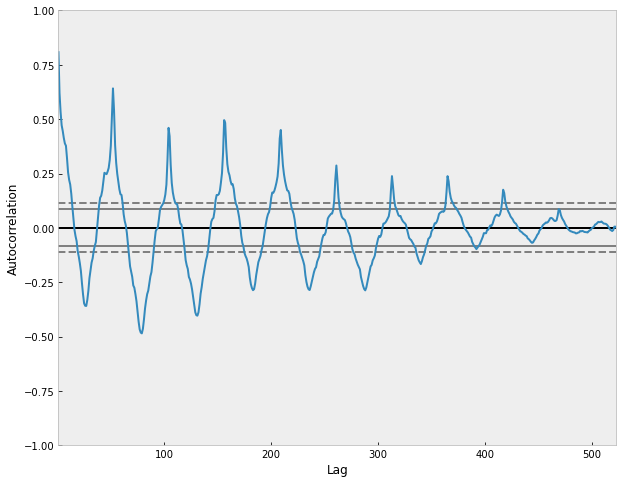

In [43]:
pd.plotting.autocorrelation_plot(train.Consumption.resample('W').mean())

In [44]:
y = train.Consumption.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
result

In [45]:
result.seasonal

Date
2006-01-01    -43.46
2006-01-08   -147.06
2006-01-15     -3.39
2006-01-22    103.17
2006-01-29    125.75
               ...  
2015-12-06    135.76
2015-12-13    115.90
2015-12-20    -43.46
2015-12-27   -147.06
2016-01-03     -3.39
Freq: W-SUN, Name: seasonal, Length: 523, dtype: float64

In [46]:
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
Date,,,,
2006-01-01,1069.18,nan,-43.46,nan
2006-01-08,1381.30,nan,-147.06,nan
2006-01-15,1486.73,nan,-3.39,nan
2006-01-22,1490.03,nan,103.17,nan
2006-01-29,1514.18,nan,125.75,nan


<AxesSubplot:xlabel='Date'>

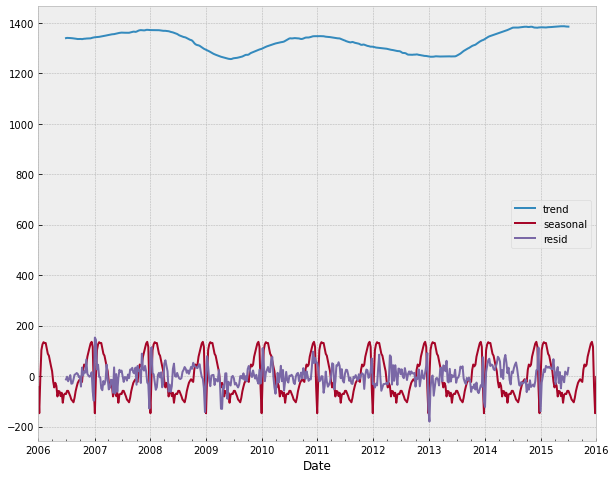

In [47]:
decomposition.iloc[:, 1:].plot()

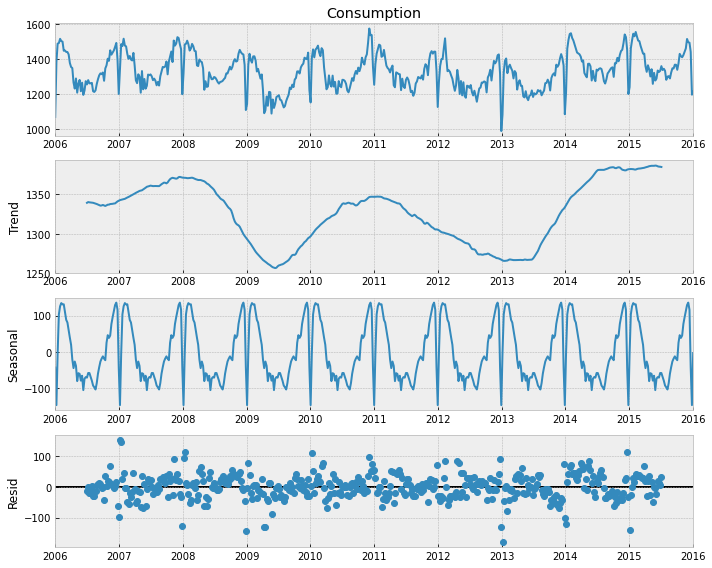

In [48]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None


In [49]:
train = train.resample('D').mean()
train.head()

,Consumption,Wind,Solar,Wind+Solar,month,year
Date,,,,,,
2006-01-01,1069.18,164.81,89.26,272.66,1,2006
2006-01-02,1380.52,164.81,89.26,272.66,1,2006
2006-01-03,1442.53,164.81,89.26,272.66,1,2006
2006-01-04,1457.22,164.81,89.26,272.66,1,2006
2006-01-05,1477.13,164.81,89.26,272.66,1,2006


In [50]:
# create a categorical feature
train['consumption_bin'] = pd.qcut(train.Consumption, 4, labels=['low', 'med_low', 'med_high', 'high'])
train.groupby('consumption_bin').Consumption.mean()

consumption_bin
low        1095.82
med_low    1297.30
med_high   1403.38
high       1523.05
Name: Consumption, dtype: float64

In [51]:
train.head()

,Consumption,Wind,Solar,Wind+Solar,month,year,consumption_bin
Date,,,,,,,
2006-01-01,1069.18,164.81,89.26,272.66,1,2006,low
2006-01-02,1380.52,164.81,89.26,272.66,1,2006,med_high
2006-01-03,1442.53,164.81,89.26,272.66,1,2006,med_high
2006-01-04,1457.22,164.81,89.26,272.66,1,2006,high
2006-01-05,1477.13,164.81,89.26,272.66,1,2006,high
